# What Makes a Movie Succesful

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle

In [2]:
# Load the data
wikidata_df = pd.read_json("./data/wikidata-movies.json.gz", lines=True)
rotten_df = pd.read_json("./data/rotten-tomatoes.json.gz", lines=True)

## Successful?
Do the various criteria for success (critic reviews, audience reviews, profit/loss) correlate with each other? 

### Audience Reviews and Critcs Reviews
We would like to know the correlation between Audience Reviews and Critcs Reviews. Are they actually depend on each other?

In [3]:
# Clean up
initial_rotten_df = rotten_df.filter(['audience_average','critic_average'], axis=1)
initial_rotten_df = initial_rotten_df.dropna()

In [4]:
# Average Ratings
fit = stats.linregress(initial_rotten_df['audience_average'], initial_rotten_df['critic_average'])
aud_critics_average = pd.DataFrame()
aud_critics_average['audience_average'] = initial_rotten_df['audience_average']
aud_critics_average['critic_average'] = aud_critics_average['audience_average']*fit.slope + fit.intercept
print("Fitted value of the average ratings:",
      "\n\tslope -> ", str(fit.slope),
      "\n\tintercept -> ", str(fit.intercept),
      "\n\trvalue -> ", str(fit.rvalue),
      "\n\tr2value -> ", str((fit.rvalue)**2),
      "\n\tpvalue -> ", str(fit.pvalue),
      "\n\tstderr -> ", str(fit.stderr)      
     )

Fitted value of the average ratings: 
	slope ->  2.2143834539977907 
	intercept ->  -1.4643721985809517 
	rvalue ->  0.6991003609011133 
	r2value ->  0.4887413146120668 
	pvalue ->  0.0 
	stderr ->  0.01750998122429251


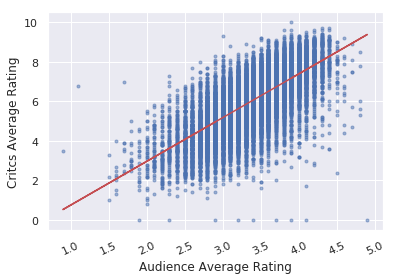

In [5]:
# General trend: Is it linear?
seaborn.set(style="darkgrid")
linegress = plt.xticks(rotation=25)
linegress = plt.ylabel("Critcs Average Rating")
linegress = plt.xlabel("Audience Average Rating")
linegress = plt.plot(initial_rotten_df['audience_average'], initial_rotten_df['critic_average'], 'b.', alpha=0.5)
linegress = plt.plot(aud_critics_average['audience_average'].values, 
                     aud_critics_average['critic_average'].values, 'r-', alpha=1)

From the plot and the slope, we can say that they are linearly correlated to each other, but is this method valid? Thus we need to check if the residual of the slope is normal.

In [6]:
aud_critics_average['residual'] = aud_critics_average['critic_average'] - initial_rotten_df['critic_average']

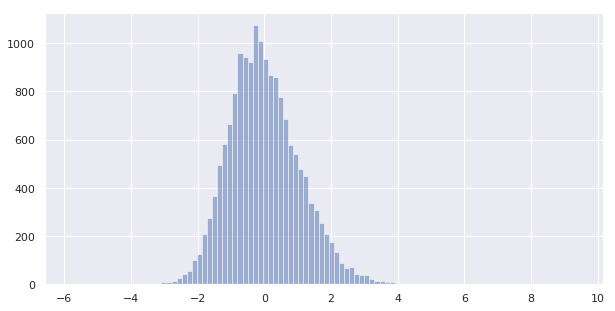

In [7]:
hist_res = plt.figure(figsize=(10, 5))
hist_res = plt.hist(aud_critics_average['residual'], alpha=0.5, bins=100)

From above, we can see that the the residual is pretty much normally distributed. This makes the linear regression valid.

### Reviews and Profits
Can we predict whether the movie made profit or loss just by using the reviews? Perhaps we could fill in the one that has average score but not whether it made profits.

In [8]:
# Clean the data
wiki_clean = wikidata_df.filter(['rotten_tomatoes_id','made_profit'], axis=1)
initial_rotten_df = rotten_df.filter(['rotten_tomatoes_id','audience_average','critic_average'], axis=1)

initial_rotten_df['audience_average'] = initial_rotten_df['audience_average']/5
initial_rotten_df['critic_average'] = initial_rotten_df['critic_average']/10

wiki_rotten = initial_rotten_df.join(wiki_clean.set_index('rotten_tomatoes_id'), on='rotten_tomatoes_id')
initial_rotten_df = initial_rotten_df.dropna()
wiki_rotten = wiki_rotten.dropna()

print("Number entries without empty average:", initial_rotten_df.shape[0])
print("Number entries without empty made_profit:", wiki_clean.dropna().shape[0])

X = wiki_rotten[['audience_average', 'critic_average']].values # Max is 5 and 10
y = wiki_rotten['made_profit'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

Number entries without empty average: 16732
Number entries without empty made_profit: 791


In [9]:
## Model Bayes
bayes_movie_model = make_pipeline(
    GaussianNB()
)
# Model KNN
knn_movie_model = make_pipeline(
    KNeighborsClassifier(n_neighbors=5)
)
# Model SVC
svc_movie_model = make_pipeline(
    SVC(kernel='rbf', C=15)
)
models = [bayes_movie_model, knn_movie_model, svc_movie_model]

In [10]:
for i, m in enumerate(models):
    m.fit(X_train, y_train)

print("Bayes accuracy: ", bayes_movie_model.score(X_test, y_test),
    "\nKNN accuracy: ", knn_movie_model.score(X_test, y_test),
    "\nSVC accuracy: ", svc_movie_model.score(X_test, y_test)
)

Bayes accuracy:  0.8478260869565217 
KNN accuracy:  0.8532608695652174 
SVC accuracy:  0.8641304347826086


In [11]:
# Do we actually has sample imbalance
num_wikiRotten = wiki_rotten.shape[0]
wiki_rotten_profit = (wiki_rotten[wiki_rotten['made_profit'] == 1].shape)[0]
wiki_rotten_loss = (wiki_rotten[wiki_rotten['made_profit'] == 0].shape)[0]
print("Percentage of movies that made profit:", str((num_wikiRotten - wiki_rotten_loss)/num_wikiRotten*100),"%")
print("Percentage of movies that made loss:", str((num_wikiRotten - wiki_rotten_profit)/num_wikiRotten*100),"%")

Percentage of movies that made profit: 84.91847826086956 %
Percentage of movies that made loss: 15.081521739130435 %


In [12]:
diff_sample = wiki_rotten_profit-wiki_rotten_loss
print("Difference in number of sample", str(diff_sample))

Difference in number of sample 514


##### Yes there is sample imbalance in this, we gonna try to fix it

The method we are going to try is make the sample more balance by dropping the sample

In [13]:
# Randomize the positive data and drop till we have same number in loss
wiki_rotten_random_prof = shuffle(wiki_rotten[wiki_rotten['made_profit'] == 1]).reset_index()
wiki_rotten_random_prof = wiki_rotten_random_prof[['rotten_tomatoes_id','audience_average', 'critic_average','made_profit']]
wiki_rotten_loss = wiki_rotten[wiki_rotten['made_profit'] == 0]
wiki_rotten_random_prof = wiki_rotten_random_prof.loc[:110]
wiki_rotten_random = wiki_rotten_random_prof.append(wiki_rotten_loss)
wiki_rotten_random = shuffle(wiki_rotten_random).reset_index()

In [14]:
wiki_rotten_random['audience_average'] = wiki_rotten_random['audience_average']/5
wiki_rotten_random['critic_average'] = wiki_rotten_random['critic_average']/10

X = wiki_rotten_random[['audience_average', 'critic_average']].values # Max is 5 and 10
y = wiki_rotten_random['made_profit'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
## Model Bayes
bayes_movie_model = make_pipeline(
    MinMaxScaler(),
    GaussianNB()
)
# Model KNN
knn_movie_model = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=5)
)
# Model SVC
svc_movie_model = make_pipeline(
    MinMaxScaler(),
    SVC(kernel='rbf', C=100)
)
models = [bayes_movie_model, knn_movie_model, svc_movie_model]

In [16]:
for i, m in enumerate(models):
    m.fit(X_train, y_train)

print("Bayes accuracy: ", bayes_movie_model.score(X_test, y_test),
    "\nKNN accuracy: ", knn_movie_model.score(X_test, y_test),
    "\nSVC accuracy: ", svc_movie_model.score(X_test, y_test)
)

Bayes accuracy:  0.6428571428571429 
KNN accuracy:  0.6964285714285714 
SVC accuracy:  0.6428571428571429


### Do the movies that made profit has higher rating?
The null hypothesis we have is "Profit means higher rating"

In [17]:
wiki_rotten_profit = wiki_rotten[wiki_rotten['made_profit'] == 1]
wiki_rotten_loss = wiki_rotten[wiki_rotten['made_profit'] == 0]

In [18]:
# Audience
aud_ratings_pvalue= stats.mannwhitneyu(
    wiki_rotten_profit['audience_average'],
    wiki_rotten_loss['audience_average']).pvalue
# Critics
crit_ratings_pvalue= stats.mannwhitneyu(
    wiki_rotten_profit['critic_average'],
    wiki_rotten_loss['critic_average']).pvalue

In [19]:
print("The Audience Average Ratings p-value:", str(aud_ratings_pvalue))
print("The Critics Average Ratings p-value:", str(crit_ratings_pvalue))

The Audience Average Ratings p-value: 1.5012176450003027e-11
The Critics Average Ratings p-value: 3.1205039528034646e-09


Both p-value are lesser than 0.05, thus we can reject the null hypothesis